## PUBG statistics
* Create a detailed stats report for matches over the last 14 days for a single player
* Create a report comparing the all-time performance of a list of players

In [1]:
import pandas as pd
import requests
from matplotlib import pyplot as plt
import os
import shutil
from datetime import datetime
import time

In [2]:
#API key to use
with open('API_KEY.txt', 'r') as keyfile:
    api_key = keyfile.read()    

## Define a player class:
Only 'Name' is provided, ID, season and match stats attributes are assigned upon initialization

In [3]:
class player():
    def __init__(self, name):
        self.name=name
        self.ID = self.get_ID()
        self.season_stats = self.get_season_stats()
        self.match_stats = self.get_match_stats()
              
    #Calls API to get ID for given player name    
    def get_ID(self):
        url = "https://api.pubg.com/shards/steam/players?filter[playerNames]="+self.name     
        header = {
          "Authorization": "Bearer "+api_key,
          "Accept": "application/vnd.api+json"
        }

        IDdata = requests.get(url, headers=header).json()
        return (IDdata['data'][0]['id'])
      
    #Calls API to get lifetime stats for given ID      
    def get_season_stats(self):
        url = f'https://api.pubg.com/shards/steam/players/{self.ID}/seasons/lifetime'          
        header = {
          "Authorization": "Bearer "+api_key,
          "Accept": "application/vnd.api+json"
        }
        raw_data = requests.get(url, headers=header).json()
        return pd.DataFrame(raw_data['data']['attributes']['gameModeStats'])
    
    
    #Calls API to get recent match stats for given name
    def get_match_stats(self):

        #First retrieve a list of recent matches for the player
        url = "https://api.pubg.com/shards/steam/players?filter[playerNames]="+self.name          
        header = {
          "Authorization": "Bearer "+api_key,
          "Accept": "application/vnd.api+json"
        }
        response = requests.get(url, headers=header).json()
        matchIDS = [response['data'][0]['relationships']['matches']['data'][i]['id'] for i,_ in enumerate(response['data'][0]['relationships']['matches']['data'])]
               
        #Get the match data  match data (map, mode, etc.) and player data (kills, etc.) for the match ID provided
        def get_match_data(match_ID):    
                url = "https://api.pubg.com/shards/steam/matches/"+match_ID       
                header = {
                  "Authorization": "Bearer "+api_key,
                  "Accept": "application/vnd.api+json"
                }

                response = requests.get(url, headers=header).json()

                match_metadata = response['data']['attributes']

                participants = [ob for ob in response['included'] if ob['type']=='participant']
                for player in participants:
                    if player['attributes']['stats']['name']==self.name:
                        match_playerdata = (player['attributes']['stats'])

                return match_metadata, match_playerdata  

        print(f'Fetching data for {self.name} (= {len(matchIDS)} matches)')
        matches_metadata=[]
        matches_playerdata=[]
        for match_ID in matchIDS:
            match_metadata, match_playerdata = get_match_data(match_ID)
            matches_metadata.append(match_metadata)
            matches_playerdata.append(match_playerdata)
        print('done')
        return pd.concat([pd.DataFrame(matches_metadata)[['createdAt', 'gameMode', 'mapName']], pd.DataFrame(matches_playerdata)], axis=1)

## Function to produce a detailed stats report of recent matches for a single player

In [4]:
def match_report(player):
    
    destination = os.getcwd() 
    
    data = player.match_stats
    playername=player.name
    earliest= data['createdAt'].min().split('T')[0]
    latest = data['createdAt'].max().split('T')[0]

    data=data.drop(['createdAt', 'name', 'playerId', 'killPoints', 'killPointsDelta', 'lastKillPoints', 'lastWinPoints', 'mostDamage', 'rankPoints', 'winPoints', 'winPointsDelta'], axis=1)
    numericals = data[['damageDealt', 'longestKill', 'rideDistance', 'swimDistance', 'timeSurvived', 'walkDistance', 'killPlace', 'winPlace']] 
    categoricals = data.drop(numericals.columns, axis=1)

    fig = plt.figure(figsize=(25,35), dpi=100) 
    fig.suptitle(f'{playername}\'s match history, {earliest} to {latest}. #rounds = {len(data)}', fontsize=40)  

    for i,col in enumerate(data.columns):
        plt.subplots_adjust(top=0.85)
        fig.add_subplot(6, 4, i+1, xmargin=0.5, ymargin=0.5)
        fig.subplots_adjust(wspace=0.5, hspace=0.5)
        plt.subplots_adjust(top=0.95)
        if col in categoricals:
            data[col].value_counts().sort_index().plot(kind='bar', title=col)
        elif col in numericals:
            data[col].plot(kind='hist', title=col, xlim=(0, max(data[col])))

    today = datetime.today().strftime('%Y-%m-%d')      
    fig.savefig(f'{destination}\\{playername}-{today}.jpg')  

## Function to produce a season report comparing a list of players

In [5]:
def season_report(players, plots_to_drop, modes):
    
    #Set up results directories
    names = [p.name for p in players]
    cwd = os.getcwd()    
    destination = os.path.join(cwd, 'Season_'+ '-'.join(names)) 
    if not os.path.exists(destination):
        os.makedirs(destination)
    else:
        shutil.rmtree(destination)           
        os.makedirs(destination) 
    
    #Concatenate players season stats into one dataframe
    all_data = pd.concat([p.season_stats for p in players], axis=1, keys = names)
    all_data = all_data.transpose()
    all_data.fillna(0, inplace=True)
    all_data = all_data[all_data['roundsPlayed']!=0]
    all_data.drop('rankPointsTitle', axis=1, inplace=True)
    all_data.to_excel('-'.join(names)+'.xls')      #save to excel file
    shutil.move('-'.join(names)+'.xls', destination)
    for col in ['assists', 'boosts', 'dBNOs', 'damageDealt', 'headshotKills', 'heals',
       'kills', 'losses', 'revives', 'rideDistance', 'roadKills', 'suicides', 'swimDistance', 'teamKills', 
        'timeSurvived', 'top10s', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'wins']:  
        all_data[col] = all_data[col] / all_data['roundsPlayed']

   
    all_data = all_data.drop(plots_to_drop, axis=1)                                           

    for m in modes:                                                    
        fig = plt.figure(figsize=(40,35), dpi=100)
        fig.suptitle('PUBG Lifetime (since Jan. 2018) stats per round (where applicable) \n Players: '+', '.join(names)+'\n Mode: '+m, fontsize=40)  
        print(f'Comparing players in mode {m}')
        for i,col in enumerate(all_data.columns):
            fig.add_subplot(4, 8, i+1, xmargin=0.5, ymargin=0.5)
            fig.subplots_adjust(wspace=0.5, hspace=0.5)
            all_data.xs(m, level=1)[col].plot(kind='bar', title=col)
            fig.savefig(destination+'\\'+m)                         #Save figure to file

Create some players:

In [6]:
simon = player('simonr0204')
dmitri = player('01zaporozhets')
dragos = player('dragman')
time.sleep(60)   #10 requests allowed per minute
choco = player('chocoTaco')

Fetching data for simonr0204 (= 105 matches)
done
Fetching data for 01zaporozhets (= 97 matches)
done
Fetching data for dragman (= 50 matches)
done
Fetching data for chocoTaco (= 421 matches)
done


Season report:

Comparing players in mode solo-fpp
Comparing players in mode duo-fpp
Comparing players in mode squad-fpp


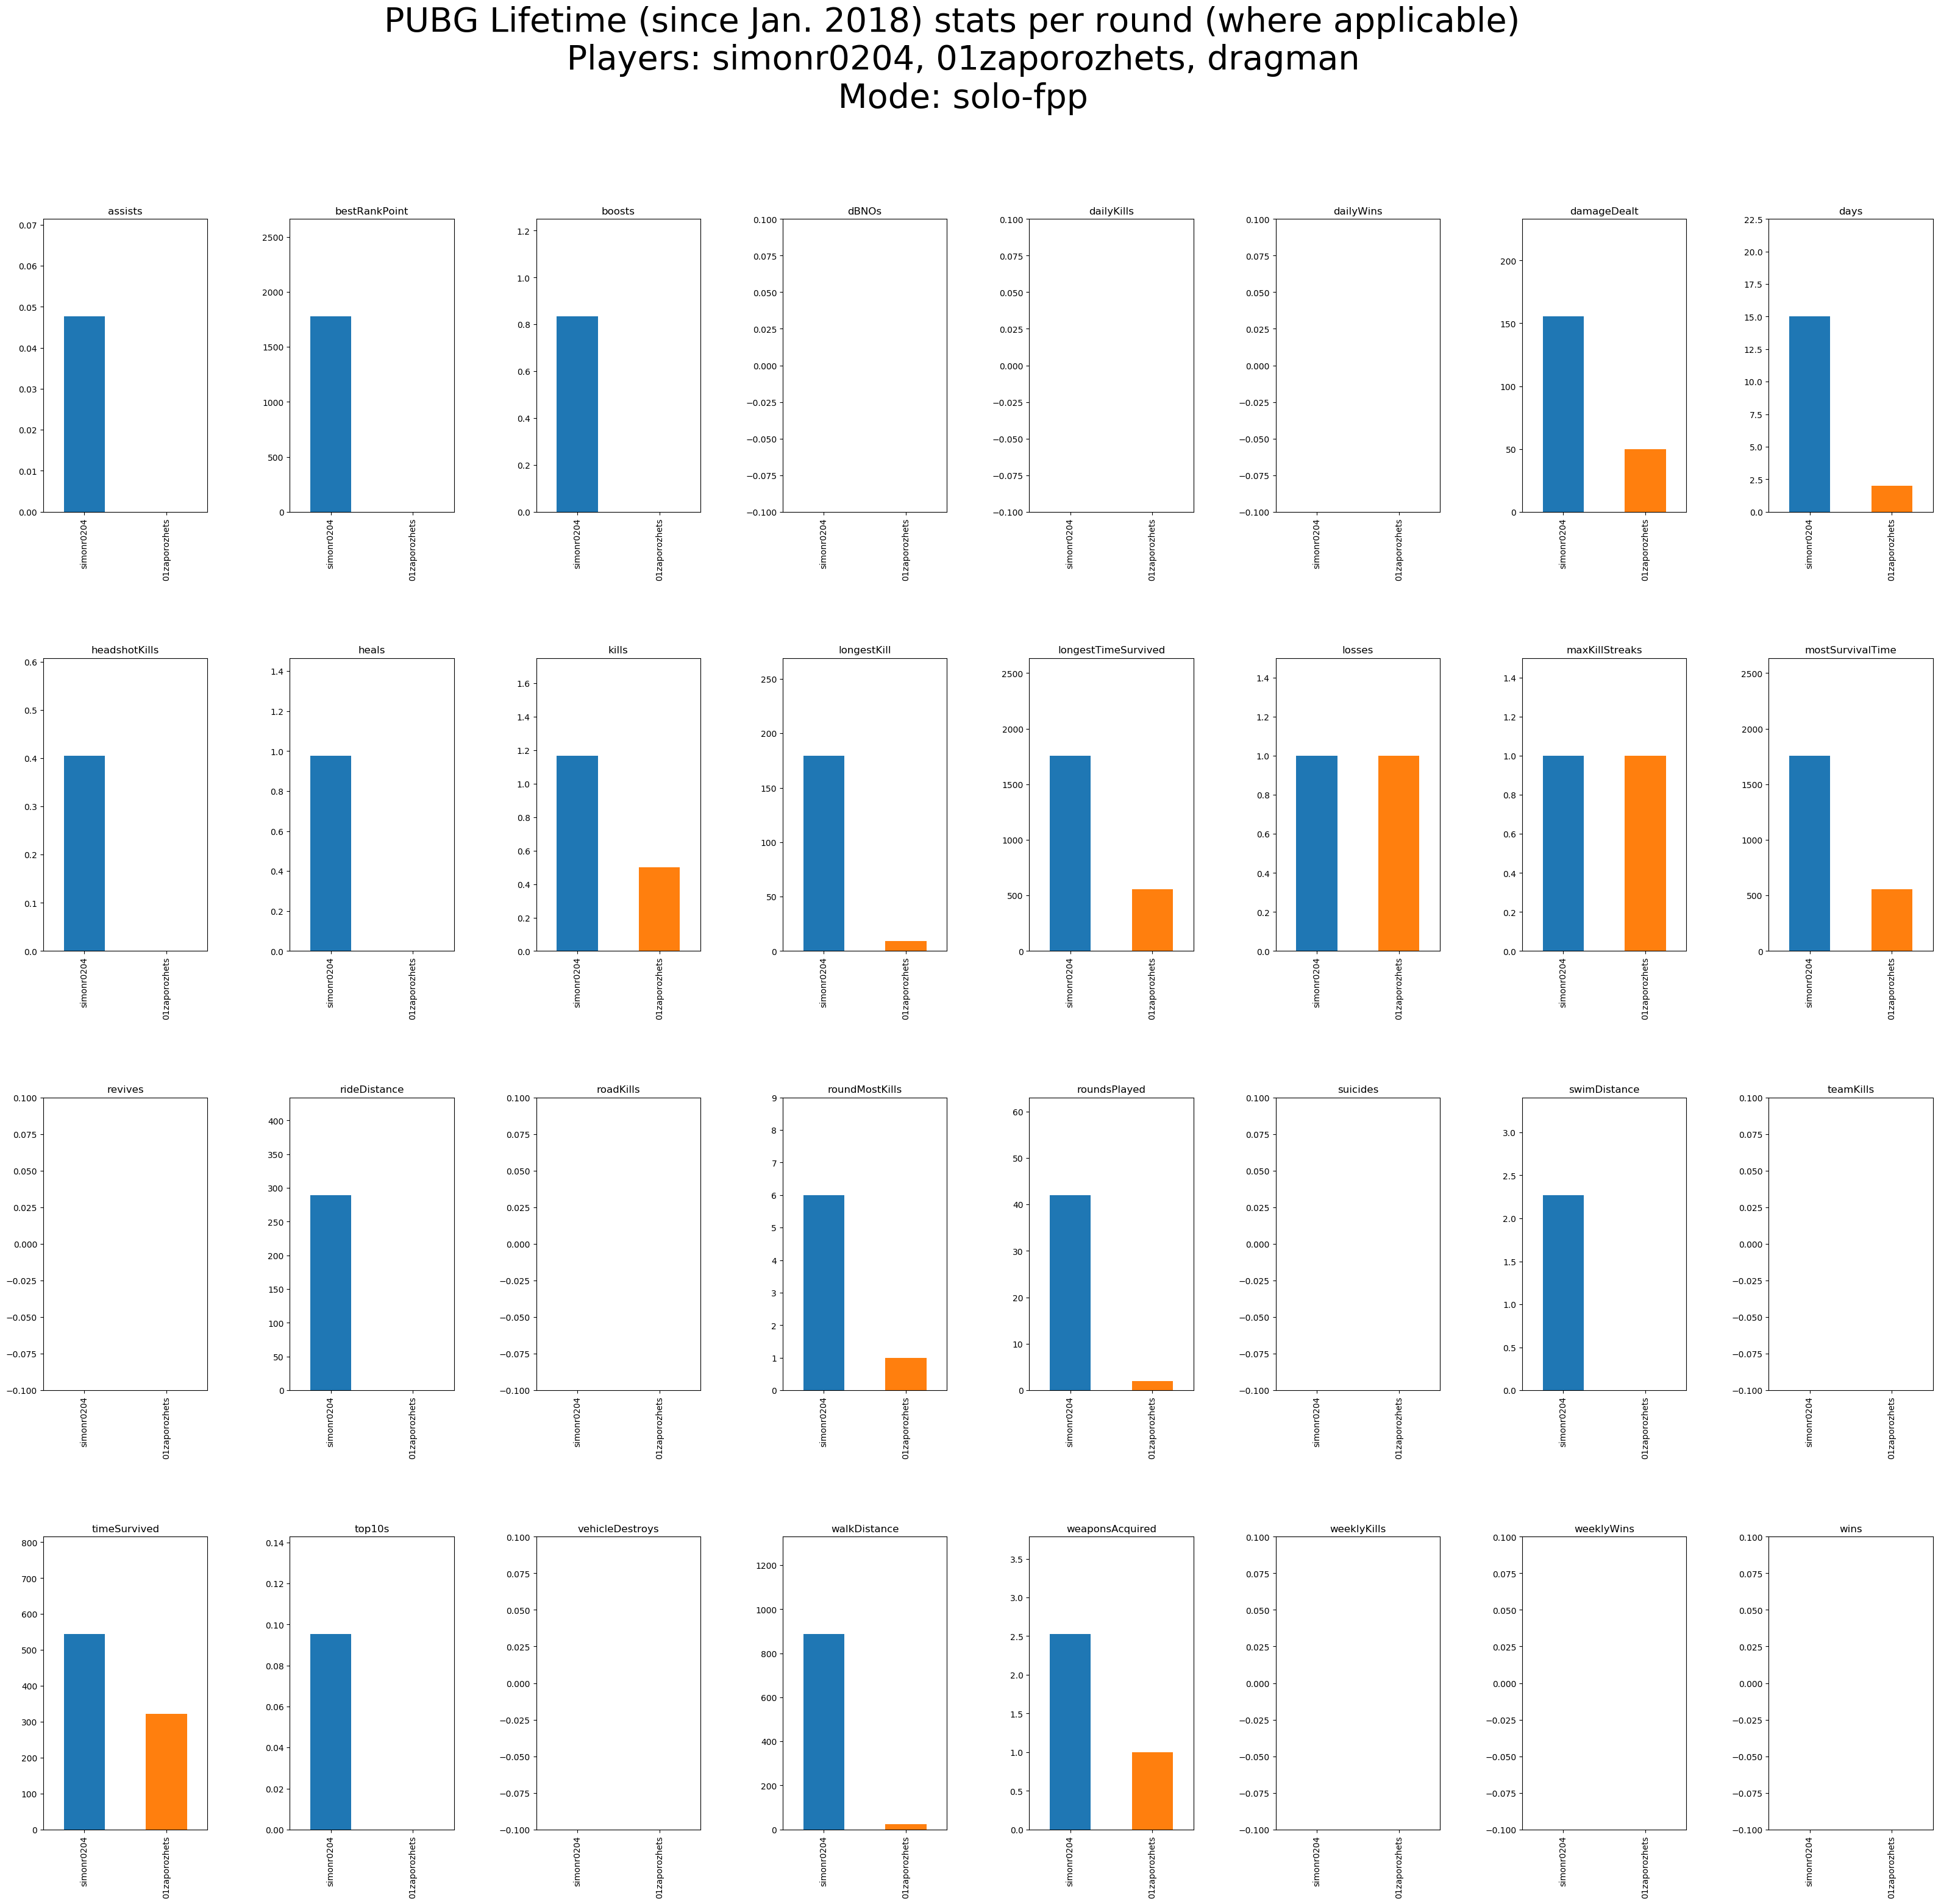

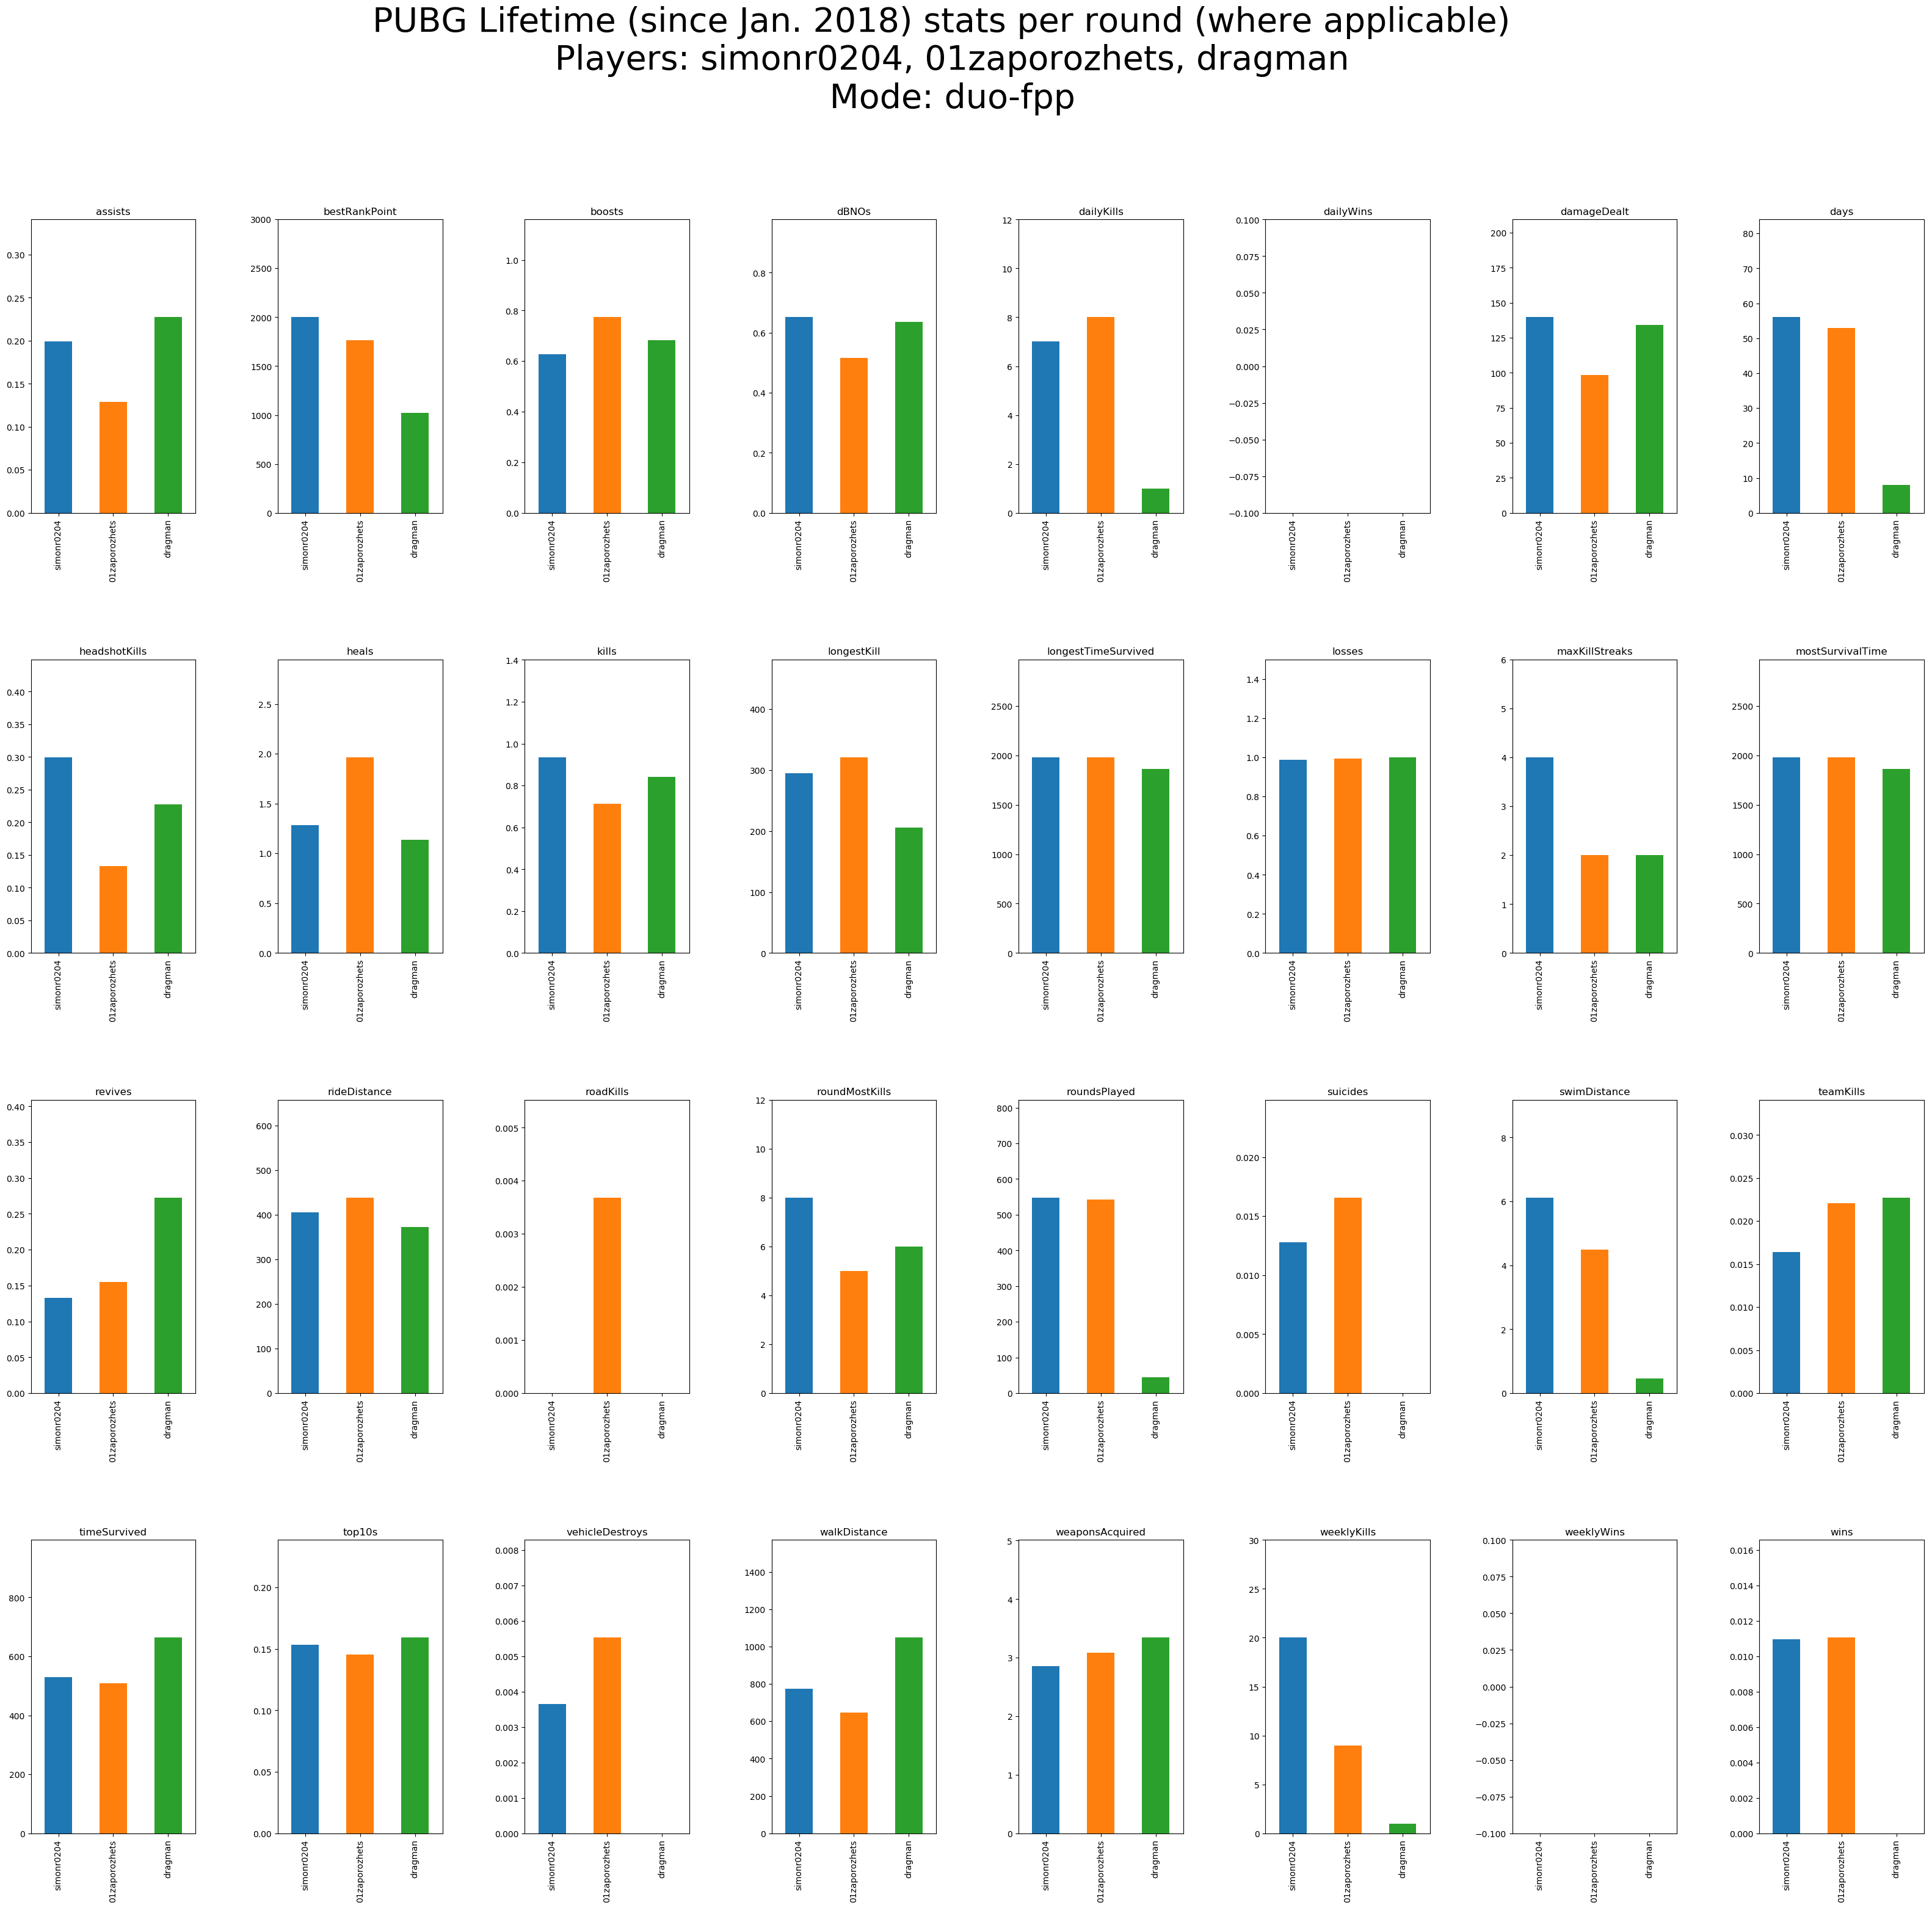

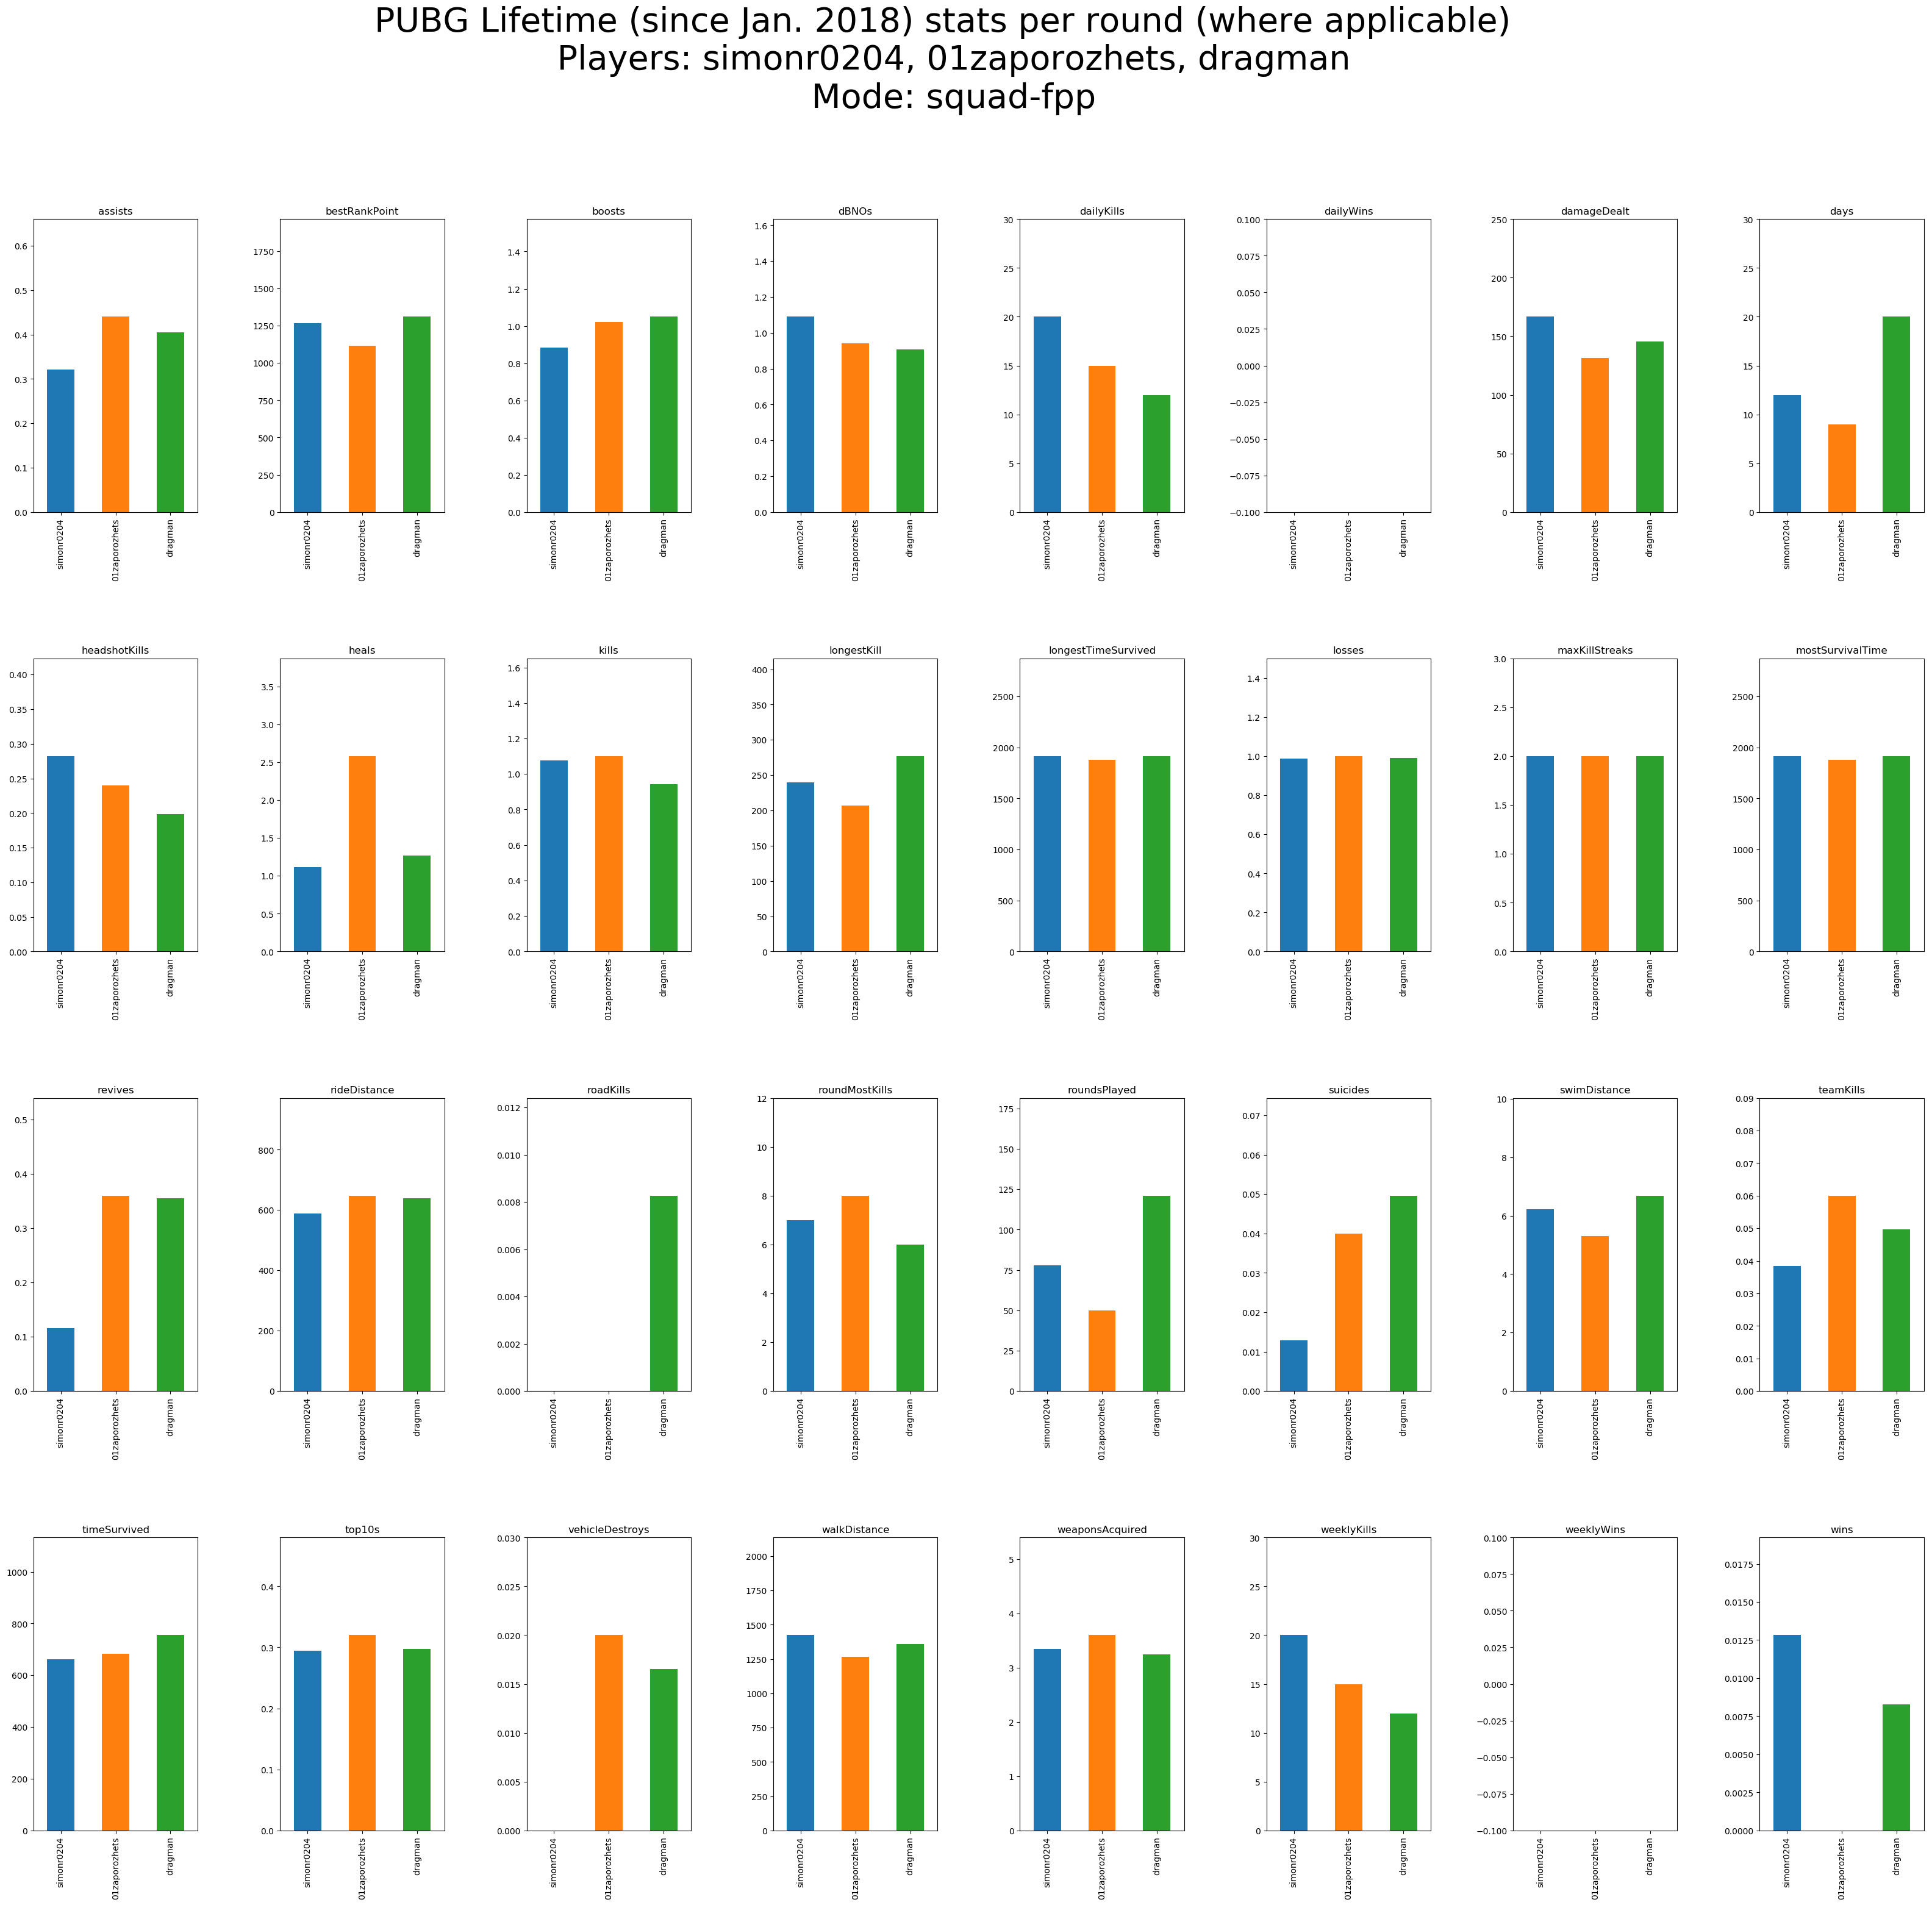

In [7]:
plots_to_drop = ['rankPoints','killPoints','winPoints']
modes = ['solo-fpp', 'duo-fpp' , 'squad-fpp']
season_report([simon, dmitri, dragos], plots_to_drop, modes)

Detailed recent matches report:

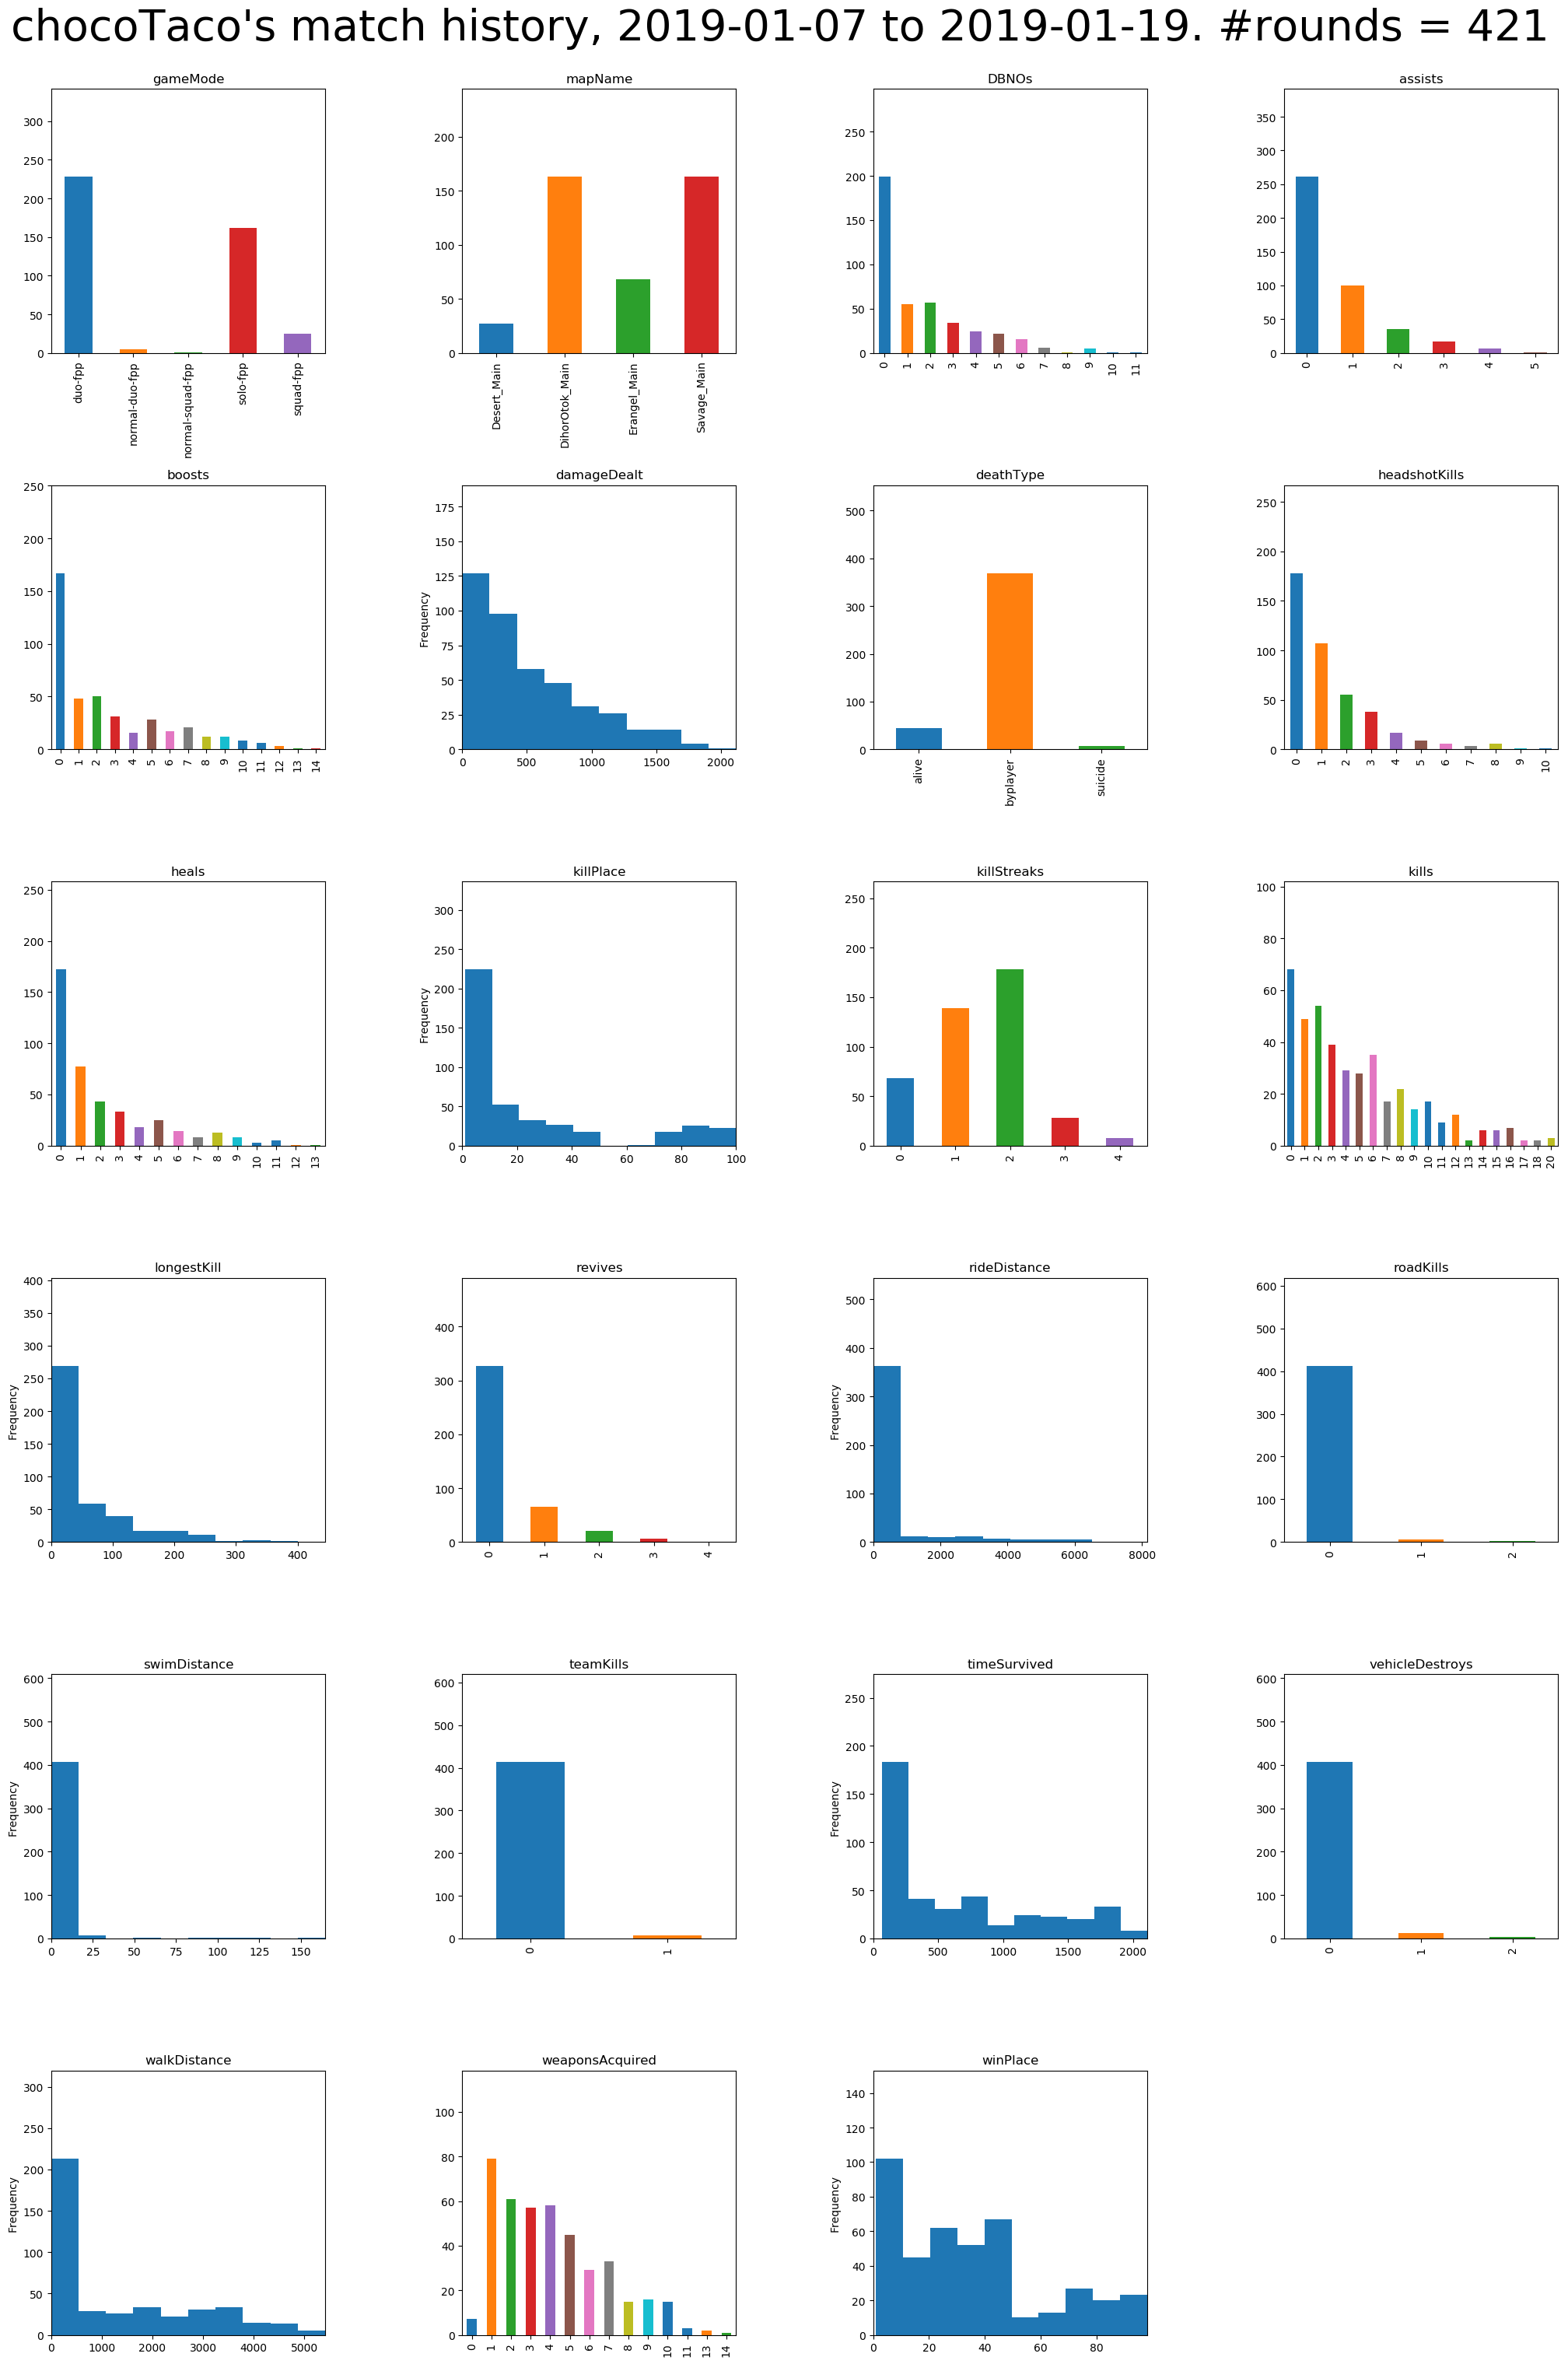

In [8]:
match_report(choco)